# Purpose of Exploration

The purpose of this notebook is to start to implament other image segmentation styles and get a better idea of how we can use them to best break up and segment our images.  The main focus of this notebook for me right now is to explore the differences between the Watershed and the P algorithm for image segmentation using the Open CV and Mabmba packages for python.

Edit: so, turns out that mamba is actually a unit test package, and I need to figure out how to import the build from GitHub.  I like the outputs that the P algorithm gives for complicated images, and it could be good to play with, I just need to get it in to Python first...

In [7]:
import cv2
# from mamba import * 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import argparse
#import imutils
from skimage.measure import label, regionprops

Text(0.5, 1.0, 'SciKit Image + Open CV bf Transform')

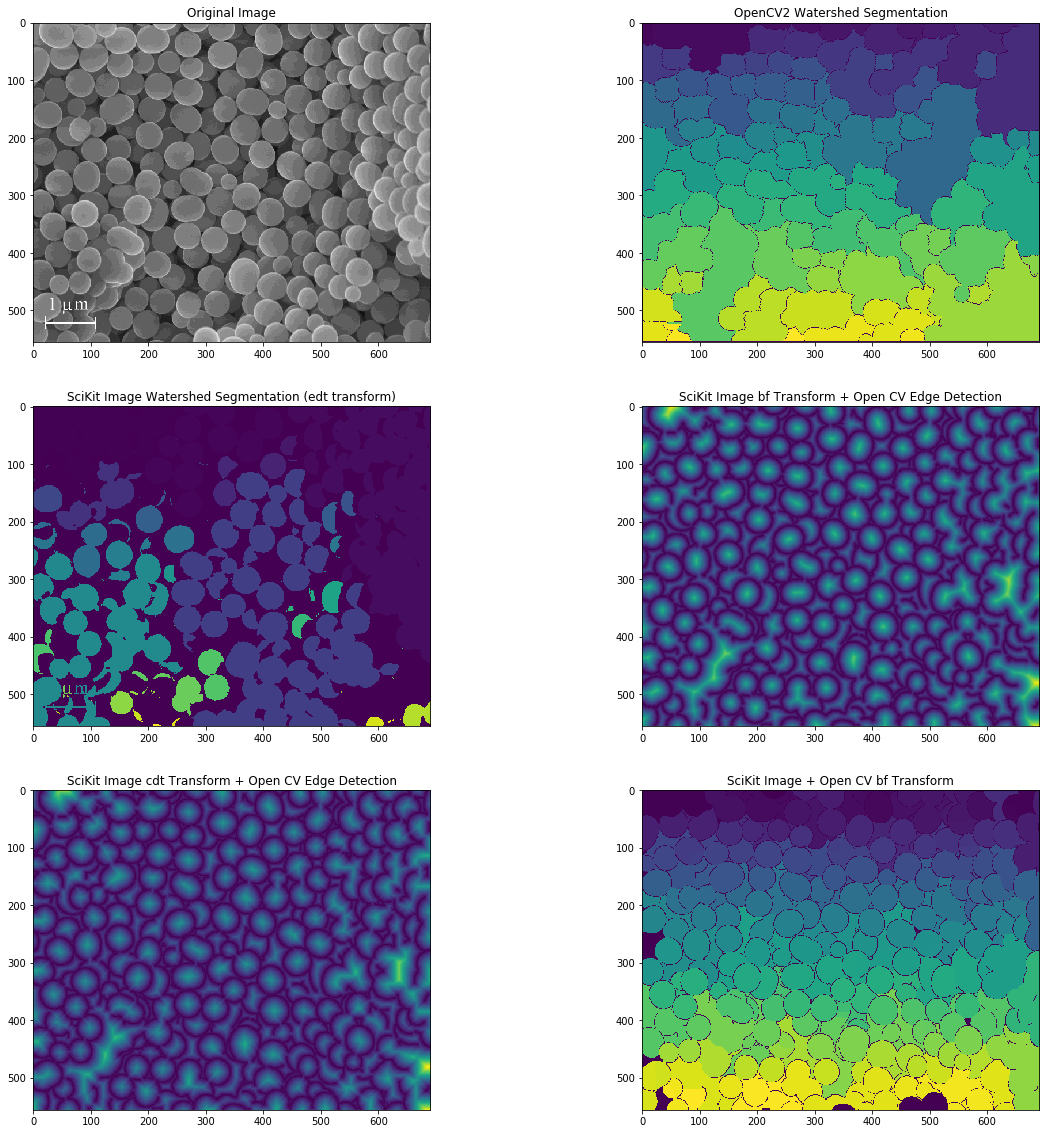

In [2]:
# Image Import of Test Image
img_opal = cv2.imread('Opal_tecopa_near_gem.jpg')
img_opal = np.array(img_opal, dtype=np.uint8)

# Watershed Segmentation of the Image
kernel_wat = np.ones((5,6), np.uint8)
opening_wat = cv2.morphologyEx(img_opal, cv2.MORPH_OPEN, kernel_wat)
canny_wat = cv2.Canny(opening_wat,100,150,3,L2gradient=True)
ret, thresh = cv2.threshold(canny_wat,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel_wat, iterations = 5) #Why do we need this and the other 'opening'?
ret, markers = cv2.connectedComponents(opening)
markers_watershed = cv2.watershed(img_opal,markers)

# SKImage Watershed
#kernal_skwat = zeros(len())
shifted_sk = cv2.pyrMeanShiftFiltering(img_opal, 1, 50)
gray_sk = cv2.cvtColor(shifted_sk, cv2.COLOR_BGR2GRAY)
thresh_sk = cv2.threshold(gray_sk, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
# Image segmentation is happening before here, obviously not able to handle these images that well.
D = ndimage.distance_transform_edt(thresh_sk)
markers_sk = ndimage.label(thresh_sk)[0]
labels_sk = watershed(-D, markers_sk, mask=thresh_sk)

# What if I tried mixing things up?
D_bf_cv = ndimage.distance_transform_bf(thresh)
D_cdt_cv = ndimage.distance_transform_cdt(thresh)
localMax = peak_local_max(D_bf_cv, indices=False, min_distance=20,labels=thresh)
markers_cv = ndimage.label(localMax)[0]
labels_bf_cv = watershed(-D_bf_cv, markers_cv, mask=thresh)

# Mamba P Alg Segmentation of the Image


# Image Plotting
fig, ax = plt.subplots(3,2,figsize=(20,20))
ax[0,0].imshow(img_opal)
ax[0,0].set_title('Original Image')

ax[0,1].imshow(markers_watershed)
ax[0,1].set_title('OpenCV2 Watershed Segmentation')

ax[1,0].imshow(labels_sk)
ax[1,0].set_title('SciKit Image Watershed Segmentation (edt transform)')

ax[1,1].imshow(D_bf_cv)
ax[1,1].set_title('SciKit Image bf Transform + Open CV Edge Detection')

ax[2,0].imshow(D_cdt_cv)
ax[2,0].set_title('SciKit Image cdt Transform + Open CV Edge Detection')

ax[2,1].imshow(labels_bf_cv)
ax[2,1].set_title('SciKit Image + Open CV bf Transform')



In [4]:
particles = label(labels_bf_cv)
particles

array([[  1,   1,   1, ...,  12,  12,  12],
       [  1,   1,   1, ...,  12,  12,  12],
       [  1,   1,   1, ...,  12,  12,  12],
       ...,
       [172, 172, 172, ..., 148, 148, 148],
       [172, 172, 172, ..., 148, 148, 148],
       [172, 172, 172, ..., 148, 148, 148]])

In [8]:
# Shamelessly stolen from the class notebook just to see if it works...
props = regionprops(labels_bf_cv, intensity_image=gray_sk)
x = np.zeros(len(props))
y = np.zeros(len(props))
area = np.zeros(len(props))
perim = np.zeros(len(props))
intensity = np.zeros(len(props))

# Use this to pull out the relevant information and save to Pandas dataframe
counter = 0
for prop in props:
    x[counter] = prop.centroid[0]
    y[counter] = prop.centroid[1]
    area[counter] = prop.area
    perim[counter] = prop.perimeter
    intensity[counter] = prop.mean_intensity
    
    counter += 1

regionprops = pd.DataFrame({'X': x, 'Y': y, 'Area': area,
                            'Perim': perim, 'Mean Intensity': intensity})

In [10]:
regionprops

,X,Y,Area,Perim,Mean Intensity
0,21.881489,55.029162,4835.0,541.847763,139.784902
1,20.245591,657.975180,1531.0,280.752309,116.156107
2,39.532803,638.912525,503.0,93.734019,141.007952
3,27.442793,411.116216,2220.0,230.444697,126.863964
4,24.889528,209.872842,3476.0,605.522907,120.752014
5,22.648518,367.719677,1855.0,315.036580,77.293261
6,28.627109,587.182083,1719.0,193.959415,126.698662
7,26.333708,145.740075,2670.0,226.852814,148.251311
8,31.452174,452.800791,1265.0,237.965512,78.026877
9,48.750753,286.472272,3318.0,458.552345,101.572634
